Importing the libraries and defining the parameters

In [83]:
# Importing the neccessary libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfreqz, sosfilt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVC  # Import Support Vector Classification from scikit-learn
from sklearn.neural_network import MLPClassifier  # Import Multi-layer Perceptron classifier from scikit-learn
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import umap

# Defining the initial values for the parameters
NumSegEpoch_Test=42     #Number of segments in each epoch (for testing session)
NumSegEpoch_Train=34    #Number of segments in each epoch (for training session)
NumAllSeg_Test=1890     #Number of all recorded segments for test set 
NumAllSeg_Train=612     #Number of all recorded segments for train set 
NumAllSegSeq=540        #Number of segments that we have for each stimulus sequence
segment_sam=252         #The length of each cVEP segment 
NumContinousSeg=6       #Number of segments that are shown continously
NumSequence=3           #Number of reference sequences
NumTarget=6             #Number of targets for each stimulus sequence
NumTargetSegment=90     #Number of EEG segments we have for each stimulus target
SampleRate=250          #Sample rate of the EEG recorder
NumUsedTrain=204         #Number of trials that are used for training

#Order of stimulus sequences while they were shown to the subjects in the test session
SequenceOrder_Test=np.array([3,1,2,3,2,1,1,2,3,2,1,3,2,3,1,1,2,3,3,1,2,1,2,3,1,3,2,3,1,2,2,3,1,1,2,3,2,1,3,1,3,2,3,1,2])

#Order of visual targets which are shown for each visual stimulus sequence (first row is for stimulus sequence 1 and so on)
TargetOrder=np.array([[3,4,2,5,6,1,4,2,6,1,5,3,2,1,3,6,5,4,2,4,6,3,5,1,5,4,6,1,2,3,2,1,5,3,4,6,2,6,5,4,3,1,3,1,4,5,2,6,1,6,3,4,2,5,2,6,1,3,5,4,2,3,6,1,5,4,3,2,6,5,4,1,6,1,3,2,4,5,2,6,1,3,4,5,1,3,4,6,5,2],
                      [2,4,5,1,6,3,2,3,5,1,4,6,1,4,2,3,6,5,5,1,3,6,2,4,5,1,6,4,3,2,4,3,2,6,1,5,2,4,3,5,6,1,4,6,3,2,5,1,6,2,1,3,4,5,6,5,4,1,2,3,3,2,1,4,6,5,3,5,1,2,6,4,2,1,5,6,3,4,5,6,2,3,4,1,1,2,6,5,3,4],
                      [6,3,5,1,2,4,1,5,3,4,2,6,3,1,2,6,5,4,1,3,2,5,6,4,6,2,3,4,1,5,3,6,4,5,1,2,3,2,1,6,4,5,2,4,3,1,6,5,2,5,3,6,1,4,4,3,2,5,1,6,4,2,6,3,5,1,1,3,4,5,2,6,6,4,5,1,2,3,6,4,2,5,1,3,3,2,1,5,6,4]])

#Labels of data for the test data
SubLabel=['S5_testing.mat','S7_testing.mat','S9_testing.mat','S13_testing.mat','S15_testing.mat']

#Threshold values for the test set
SubjThresh=[14.1,14.3,13.45,14.1,14.1]

#Determine the order of sequences for the train session
SequenceOrder_Train=[3,1,2,3,2,1,1,2,3,2,1,3,2,3,1,1,2,3]

#Labels of data for the train data
SubLabel_Train=['S5_training.mat','S7_training.mat','S9_training.mat','S13_training.mat','S15_training.mat']

#Threshold values for the test set
SubjThresh_Train=[13.8,14.05,13.1,13.7,13.8]

# Function to create a bandpass filter
def butter_bandpass(lowcut,highcut,fs,order):
    nyquist=0.5*fs
    low=lowcut/nyquist
    high=highcut/nyquist
    sos=butter(order,[low,high],btype='band',analog=False, output='sos')
    return sos

# Function to apply the bandpass filter to a signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    sos=butter_bandpass(lowcut,highcut,fs,order)
    y=sosfilt(sos,data)
    return y

# Defining the parameters of the bandpass filter  
Lowcut_Freq=2      #Low cutoff frequency
Highcut_Freq=40    #High cutoff frequency
FilterOrder=8      #Order of filter

# Defining some arrays for storing the values of accuracies of different subjects for each classifier 
TemplateMatching_Acc=np.zeros(len(SubLabel))
SVM_Acc=np.zeros(len(SubLabel))
RandomForest_Acc=np.zeros(len(SubLabel))
NaiveBaysed_Acc=np.zeros(len(SubLabel))
KNNeigbors_Acc=np.zeros(len(SubLabel))
XGBoost_Acc=np.zeros(len(SubLabel))
DeepNN_Acc=np.zeros(len(SubLabel))
CNN_Acc=np.zeros(len(SubLabel))

MeanSegments_Seq1=[0,0,0,0,0,0]
MeanSegments_Seq2=[0,0,0,0,0,0]
MeanSegments_Seq3=[0,0,0,0,0,0]
ShiftVal=np.array([44,0,-40,-84,-124,-168])   #The shifting values to produce the EEG templates of other targets based on the reference target 
ShiftedArray_Seq1=[0,0,0,0,0,0]
ShiftedArray_Seq2=[0,0,0,0,0,0]
ShiftedArray_Seq3=[0,0,0,0,0,0]


SubjTemp=np.zeros((5,252))
SubjTestTrials=np.array([])

Filtering, EEG extraction, and structuring the EEG data for visualization and classification purposes step by step

In [84]:
#--------------------------------------------------------------------------------------------------------------------------------------------------------------#
# Section 2: reading the data in Python
for SubIndex in range(len(SubLabel)):
    InputData=loadmat(SubLabel[SubIndex])
    AllData_Test=InputData['testing_data']

    Synch_Sig_Test=AllData_Test[0,:]   # Synchronization signal
    EEG_Sig_Test=AllData_Test[1,:]     # EEG data

    num_samples=len(EEG_Sig_Test)
    total_duration=num_samples/SampleRate #Total duration in second
    time_vector_test=np.arange(0,total_duration,1/SampleRate) # Create a time vector
    
#--------------------------------------------------------------------------------------------------------------------------------------------------------------#
    InputData=loadmat(SubLabel_Train[SubIndex])
    AllData_Train=InputData['training_data']

    Synch_Sig_Train=AllData_Train[0,:]   # Synchronization signal
    EEG_Sig_Train=AllData_Train[1,:]     # EEG data

    num_samples=len(EEG_Sig_Train)
    total_duration=num_samples/SampleRate #Total duration in second
    time_vector_train=np.arange(0,total_duration,1/SampleRate) # Create a time vector
    #---------------------------------------------------------------------------------------------------------------------------------------------------------------#
# Section3: Filtering the EEG signals    
    # Apply bandpass filter
    Filtered_EEG_Sig_Test=butter_bandpass_filter(EEG_Sig_Test,Lowcut_Freq,Highcut_Freq,SampleRate,FilterOrder)

    # Apply bandpass filter
    Filtered_EEG_Sig_Train=butter_bandpass_filter(EEG_Sig_Train,Lowcut_Freq,Highcut_Freq,SampleRate,FilterOrder)
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------------#
# Section4: Extracting the EEG segments
    # Transform the synchronization signal to a binary signal 
    
    Synch_Sig_Binary_Test=np.zeros(len(Synch_Sig_Test))
    for i in range(len(Synch_Sig_Test)):
        if Synch_Sig_Test[i] >= SubjThresh[SubIndex]:
            Synch_Sig_Binary_Test[i]=1
        else:
            Synch_Sig_Binary_Test[i]=0

    # Determine the onset of each EEG segment in the EEG signal 
    def Segment_Onset(Synch_Sig):
        y=[]
        for i in range(1,len(Synch_Sig)):
            if Synch_Sig[i]-Synch_Sig[i-1]==1:
                y=y+[i]
        return y
    Segment_Onset_Index=Segment_Onset(Synch_Sig_Binary_Test)

    # Determine the label of each EEG segment based on our three reference stimulus sequences (1:m-sequence, 2:TFO, 3:6TO)
    SegmentLabelSeq=np.array([])
    for i in range(len(SequenceOrder_Test)):
        SegmentLabelSeq=np.concatenate((SegmentLabelSeq , np.repeat(SequenceOrder_Test[i],NumSegEpoch_Test)))
    SegmentLabelSeq=np.array(SegmentLabelSeq.reshape(NumAllSeg_Test,1))

    # Produce an array in which each row is one EEG segment. The order of rows is based on the array which contains the EEG segments.
    SegmentArray=np.zeros((NumAllSeg_Test,segment_sam))
    for i in range(NumAllSeg_Test):
        SegmentArray[i,:]=Filtered_EEG_Sig_Test[Segment_Onset_Index[i]:(Segment_Onset_Index[i]+segment_sam)]
        MeanValue=np.mean(SegmentArray[i,:])
        SegmentArray[i,:]=SegmentArray[i,:]-MeanValue

    # Extracting the EEG segments related to each reference stimulus sequence m-sequence, TFO, and 6TO and put them beside each other in individial arrays. (1:m-sequence, 2:TFO, 3:6TO)
    # I used the label vector and EEG array which was produced previously for organizing the EEG segments
    StimSeq1_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 1))  # Extracting the indices of EEG segments related to stimulus sequence 1 (m-sequence)
    StimSeq1_AllSegments_Test=SegmentArray[StimSeq1_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 1 (m-sequence)

    StimSeq2_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 2))  # Extracting the indices of EEG segments related to stimulus sequence 2 (TFO)
    StimSeq2_AllSegments_Test=SegmentArray[StimSeq2_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 2 (TFO) 

    StimSeq3_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 3))  # Extracting the indices of EEG segments related to stimulus sequence 3 (6TO)
    StimSeq3_AllSegments_Test=SegmentArray[StimSeq3_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 3 (6TO)

#---------------------------------------------------------------------------------------------------------#
    # Transform the synchronization signal to a binary signal 
    Synch_Sig_Binary_Train=np.zeros(len(Synch_Sig_Train))
    for i in range(len(Synch_Sig_Train)):
        if Synch_Sig_Train[i] >= SubjThresh_Train[SubIndex]:
            Synch_Sig_Binary_Train[i]=1
        else:
            Synch_Sig_Binary_Train[i]=0

    #plt.plot(Synch_Sig_Binary)

    # Determine the onset of each EEG segment in the EEG signal 
    def Segment_Onset(Synch_Sig):
        y=[]
        for i in range(1,len(Synch_Sig)):
            if Synch_Sig[i]-Synch_Sig[i-1]==1:
                y=y+[i]
        return y
    Segment_Onset_Index=Segment_Onset(Synch_Sig_Binary_Train)
    #print('Onset index of EEG segments: ',Segment_Onset_Index)

    # Determine the label of each EEG segment based on our three reference stimulus sequences (1:m-sequence, 2:TFO, 3:6TO)
    SegmentLabelSeq=np.array([])
    for i in range(len(SequenceOrder_Train)):
        SegmentLabelSeq=np.concatenate((SegmentLabelSeq , np.repeat(SequenceOrder_Train[i],NumSegEpoch_Train)))
    SegmentLabelSeq=np.array(SegmentLabelSeq.reshape(NumAllSeg_Train,1))
    #print('Size of the vector containing the labels of EEG segments: ', np.shape(SegmentLabelSeq))

    # Produce an array in which each row is one EEG segment. The order of rows is based on the array which contains the EEG segments.
    SegmentArray=np.zeros((NumAllSeg_Train,segment_sam))
    for i in range(NumAllSeg_Train):
        SegmentArray[i,:]=Filtered_EEG_Sig_Train[Segment_Onset_Index[i]:(Segment_Onset_Index[i]+segment_sam)]
        MeanValue=np.mean(SegmentArray[i,:])
        SegmentArray[i,:]=SegmentArray[i,:]-MeanValue
    #print('Size of the array containing all the EEG segments: ',np.shape(SegmentArray))

    # Extracting the EEG segments related to each reference stimulus sequence m-sequence, TFO, and 6TO and put them beside each other in individial arrays. (1:m-sequence, 2:TFO, 3:6TO)
    # I used the label vector and EEG array which was produced previously for organizing the EEG segments
    StimSeq1_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 1))  # Extracting the indices of EEG segments related to stimulus sequence 1 (m-sequence)
    StimSeq1_AllSegments_Train=SegmentArray[StimSeq1_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 1 (m-sequence)
    #print('Size of the array containing EEG segments related to stimulus sequence 1:',np.shape(StimSeq1_AllSegments_Train))

    StimSeq2_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 2))  # Extracting the indices of EEG segments related to stimulus sequence 2 (TFO)
    StimSeq2_AllSegments_Train=SegmentArray[StimSeq2_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 2 (TFO) 

    StimSeq3_AllSegmentsIndices=np.array(np.where(SegmentLabelSeq == 3))  # Extracting the indices of EEG segments related to stimulus sequence 3 (6TO)
    StimSeq3_AllSegments_Train=SegmentArray[StimSeq3_AllSegmentsIndices[0],:]   # Extracting the EEG segments related to stimulus sequence 3 (6TO)
    
#---------------------------------------------------------------------------------------------------------#
# Section 5: Eliminating the EEG segments related to gaze shifting    
    RemovedIndices=list(range(0,629,7))   #Extracting the indices related to EEG segments specified for gaze shifting for each visual stimulus
    StimSeq1_AllSegments=np.delete(StimSeq1_AllSegments_Test,RemovedIndices,axis=0)  #Removing the gaze shifting segments from the array containing the EEG segments related to stimulus sequence 1
    StimSeq2_AllSegments=np.delete(StimSeq2_AllSegments_Test,RemovedIndices,axis=0)  #Removing the gaze shifting segments from the array containing the EEG segments related to stimulus sequence 2
    StimSeq3_AllSegments=np.delete(StimSeq3_AllSegments_Test,RemovedIndices,axis=0)  #Removing the gaze shifting segments from the array containing the EEG segments related to stimulus sequence 3
    
#--------------------------------------------------------------------------------------------------------#
# Section 6: Extracting the EEG segments related to each visual target of each stimulus sequence
    # Determine the label of each EEG segment based on the label of visual target to which it is related
    SegLabelTar_Seq1=np.array([])
    SegLabelTar_Seq2=np.array([])
    SegLabelTar_Seq3=np.array([])
    for i in range(len(TargetOrder[0,:])):
        SegLabelTar_Seq1=np.concatenate((SegLabelTar_Seq1 , np.repeat(TargetOrder[0,i],NumContinousSeg)))
        SegLabelTar_Seq2=np.concatenate((SegLabelTar_Seq2 , np.repeat(TargetOrder[1,i],NumContinousSeg)))
        SegLabelTar_Seq3=np.concatenate((SegLabelTar_Seq3 , np.repeat(TargetOrder[2,i],NumContinousSeg)))

    SegLabelTar_Seq1=np.array(SegLabelTar_Seq1.reshape(NumAllSegSeq,1))
    SegLabelTar_Seq2=np.array(SegLabelTar_Seq2.reshape(NumAllSegSeq,1))
    SegLabelTar_Seq3=np.array(SegLabelTar_Seq3.reshape(NumAllSegSeq,1))

    # Extracting the EEG segments related to each visual target for each stimulus sequence and then putting them beside each other
    Seq1_OrganizedSegments=[0,0,0,0,0,0]
    Seq2_OrganizedSegments=[0,0,0,0,0,0]
    Seq3_OrganizedSegments=[0,0,0,0,0,0]
    for i in range(1,7):
        Seq1_SegmentIndices=np.array(np.where(SegLabelTar_Seq1 == i))
        Seq1_OrganizedSegments[i-1]=StimSeq1_AllSegments[Seq1_SegmentIndices[0],:]

        Seq2_SegmentIndices=np.array(np.where(SegLabelTar_Seq2 == i))
        Seq2_OrganizedSegments[i-1]=StimSeq2_AllSegments[Seq2_SegmentIndices[0],:]

        Seq3_SegmentIndices=np.array(np.where(SegLabelTar_Seq3 == i))
        Seq3_OrganizedSegments[i-1]=StimSeq3_AllSegments[Seq3_SegmentIndices[0],:]


#-----------------------------------------------------------------------------------------------------#
#Section 7: Producing the train set and test set and label vector for each stimulus sequence
    
    Seq1_Train_Data=np.roll(StimSeq1_AllSegments_Train[0:NumUsedTrain,:],ShiftVal[0],axis=1)
    Seq2_Train_Data=np.roll(StimSeq2_AllSegments_Train[0:NumUsedTrain,:],ShiftVal[0],axis=1)
    Seq3_Train_Data=np.roll(StimSeq3_AllSegments_Train[0:NumUsedTrain,:],ShiftVal[0],axis=1)
    Seq1_Train_Label=np.full(np.size(StimSeq1_AllSegments_Train[0:NumUsedTrain,:],0),0).reshape(-1,1)
    Seq2_Train_Label=np.full(np.size(StimSeq2_AllSegments_Train[0:NumUsedTrain,:],0),0).reshape(-1,1)
    Seq3_Train_Label=np.full(np.size(StimSeq3_AllSegments_Train[0:NumUsedTrain,:],0),0).reshape(-1,1)

    for i in range (1,NumTarget):
        Seq1_Train_Data=np.concatenate((Seq1_Train_Data,np.roll(StimSeq1_AllSegments_Train[0:NumUsedTrain,:],ShiftVal[i],axis=1)),axis=0)
        Seq2_Train_Data=np.concatenate((Seq2_Train_Data,np.roll(StimSeq2_AllSegments_Train[0:NumUsedTrain,:],ShiftVal[i],axis=1)),axis=0)
        Seq3_Train_Data=np.concatenate((Seq3_Train_Data,np.roll(StimSeq3_AllSegments_Train[0:NumUsedTrain,:],ShiftVal[i],axis=1)),axis=0)
        Seq1_Train_Label=np.concatenate((Seq1_Train_Label,np.full(np.size(StimSeq1_AllSegments_Train[0:NumUsedTrain,:],0),i).reshape(-1,1)),axis=0)
        Seq2_Train_Label=np.concatenate((Seq2_Train_Label,np.full(np.size(StimSeq2_AllSegments_Train[0:NumUsedTrain,:],0),i).reshape(-1,1)),axis=0)
        Seq3_Train_Label=np.concatenate((Seq3_Train_Label,np.full(np.size(StimSeq3_AllSegments_Train[0:NumUsedTrain,:],0),i).reshape(-1,1)),axis=0)


    Seq1_Train_Label=Seq1_Train_Label.ravel()
    Seq2_Train_Label=Seq2_Train_Label.ravel()
    Seq3_Train_Label=Seq3_Train_Label.ravel()


    Seq1_Test_Data=StimSeq1_AllSegments                # Train and Test set for stimulus sequence 1
    Seq1_Test_Label=(SegLabelTar_Seq1-1).ravel()        # Label vector for stimulus sequence 1

    Seq2_Test_Data=StimSeq2_AllSegments                # Train and Test set for stimulus sequence 2
    Seq2_Test_Label=(SegLabelTar_Seq2-1).ravel()        # Label vector for stimulus sequence 2

    Seq3_Test_Data=StimSeq3_AllSegments                # Train and Test set for stimulus sequence 3
    Seq3_Test_Label=(SegLabelTar_Seq3-1).ravel()        # Label vector for stimulus sequence 3

    #print(Seq1_Test_Data.shape)
    
     
    SubjTemp[SubIndex,:]=Seq1_Train_Data[204:408,:].mean(axis=0)
    if SubIndex==0:
        Seq1_Train_Data_New=Seq1_Train_Data[204:408,:]
        SubjTestTrials=Seq1_Test_Data[np.where(SegLabelTar_Seq1-1==1)[0],:]
    else:
        Seq1_Train_Data_New=np.concatenate((Seq1_Train_Data_New,Seq1_Train_Data[204:408,:]),axis=0)
        SubjTestTrials=np.concatenate((SubjTestTrials,Seq1_Test_Data[np.where(SegLabelTar_Seq1-1==1)[0],:]),axis=0)
    #print(SubjTestTrials.shape)
    
    #print('Seq1_train_Data=',Seq1_Train_Data_New.shape)
    #print('Seq1_train_label=',Seq1_Train_Label.shape)
    #print('Seq1_test_Data=',SubjTestTrials.shape)

numbers=np.arange(5)    
Seq1_Train_Label_New= np.repeat(numbers, 204)
#print(Seq1_Train_Label_New)
#print('Seq1_train_label=',Seq1_Train_Label_New.shape)    

numbers=np.arange(5)
Seq1_Test_Label_New= np.repeat(numbers, 90)
#print(Seq1_Test_Label_New)
#print('Seq1_Test_label=',Seq1_Test_Label_New.shape)  

#print(Seq1_Test_Label)  

Visualizing the EEG responses

Text(0.5, 1.0, 'All subjects')

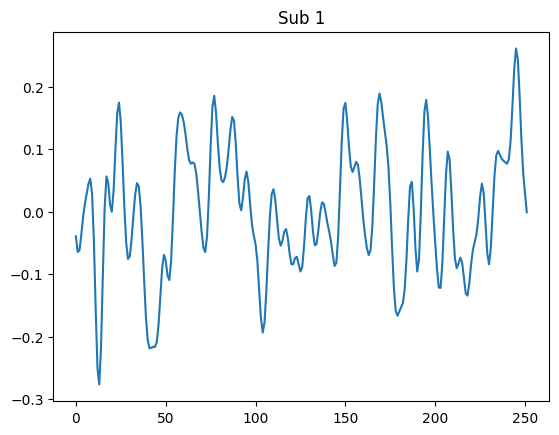

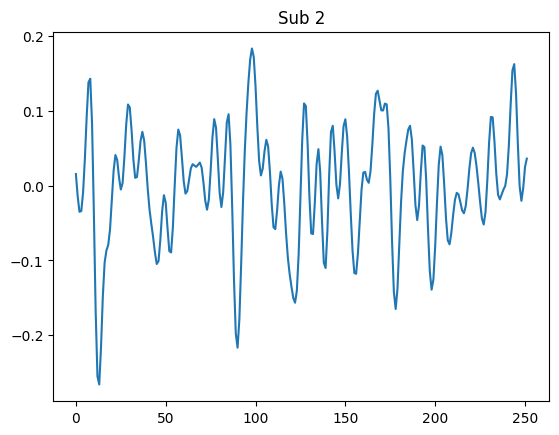

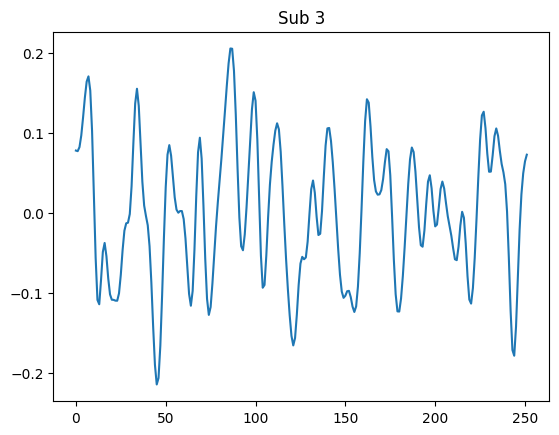

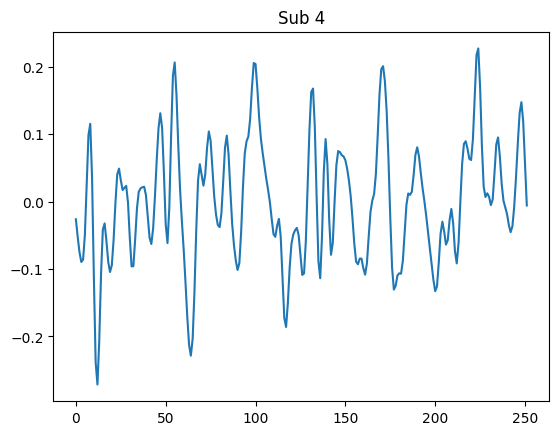

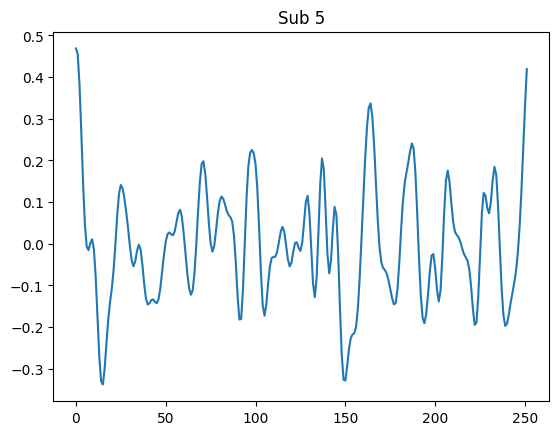

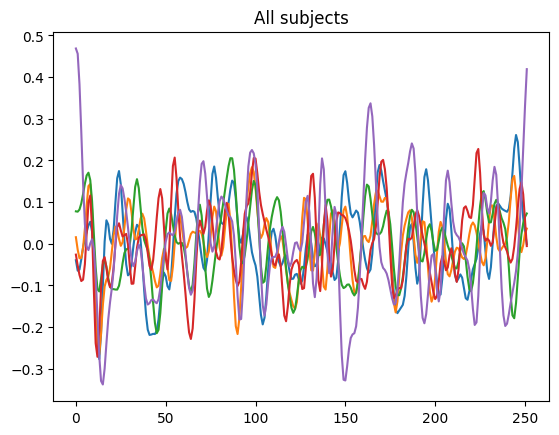

In [95]:
plt.figure(1)
plt.plot(SubjTemp[0,:])
plt.title("Sub 1")
plt.figure(2)
plt.plot(SubjTemp[1,:])
plt.title("Sub 2")
plt.figure(3)
plt.plot(SubjTemp[2,:])
plt.title("Sub 3")
plt.figure(4)
plt.plot(SubjTemp[3,:])
plt.title("Sub 4")
plt.figure(5)
plt.plot(SubjTemp[4,:])
plt.title("Sub 5")
plt.figure(6)
plt.plot(SubjTemp[0,:])
plt.plot(SubjTemp[1,:])
plt.plot(SubjTemp[2,:])
plt.plot(SubjTemp[3,:])
plt.plot(SubjTemp[4,:])
plt.title("All subjects")

#print(Seq1_Train_Label)

#plt.plot(SubjTestTrials[360:449,:].mean(axis=0))

Calculating the Calssification accuracy for the training data

In [89]:
#Implementing the classifier for training data
#Section 8: Impelemting traditional classification algorithm Template Matching as a reference
class TemplateMatchingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.templates = None
        self.labels = None

    def fit(self, X, y):
        self.labels = np.unique(y)
        self.templates = []

    # Calculate mean template for each class
        for label in self.labels:
            class_samples = X[y == label]
            class_template = np.mean(class_samples, axis=0)
            self.templates.append(class_template)

        return self

    def predict(self, X):
        predictions = []

        # Calculate correlation coefficient for each class and predict the one with the highest value
        for sample in X:
            correlation_scores = [np.corrcoef(sample, template)[0, 1] for template in self.templates]
            predicted_label = self.labels[np.argmax(correlation_scores)]
            predictions.append(predicted_label)

        return np.array(predictions)

    def score(self, X, y):
        # Use accuracy as the scoring metric
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
        
# Create an instance of the template matching classifier
template_matching_model = TemplateMatchingClassifier()

# Train the model
template_matching_model.fit(Seq1_Train_Data_New,Seq1_Train_Label_New)

# Test the model
predictions=template_matching_model.predict(Seq1_Train_Data_New)

# Evaluate the model
accuracy=accuracy_score(Seq1_Train_Label_New,predictions)
TemplateMatching_Acc=accuracy
print("Classification accuracy for the training data:",TemplateMatching_Acc*100,"%")

Classification accuracy for the training data: 90.29411764705883 %


Calculating the Calssification accuracy for the tesing data

In [90]:
#Implementing the classifier for training data
#Section 8: Impelemting traditional classification algorithm Template Matching as a reference
class TemplateMatchingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.templates = None
        self.labels = None

    def fit(self, X, y):
        self.labels = np.unique(y)
        self.templates = []

    # Calculate mean template for each class
        for label in self.labels:
            class_samples = X[y == label]
            class_template = np.mean(class_samples, axis=0)
            self.templates.append(class_template)

        return self

    def predict(self, X):
        predictions = []

        # Calculate correlation coefficient for each class and predict the one with the highest value
        for sample in X:
            correlation_scores = [np.corrcoef(sample, template)[0, 1] for template in self.templates]
            predicted_label = self.labels[np.argmax(correlation_scores)]
            predictions.append(predicted_label)

        return np.array(predictions)

    def score(self, X, y):
        # Use accuracy as the scoring metric
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
        
# Create an instance of the template matching classifier
template_matching_model = TemplateMatchingClassifier()

# Train the model
template_matching_model.fit(Seq1_Train_Data_New,Seq1_Train_Label_New)

# Test the model
predictions=template_matching_model.predict(SubjTestTrials)

# Evaluate the model
accuracy=accuracy_score(Seq1_Test_Label_New,predictions)
TemplateMatching_Acc=accuracy
print("Classification accuracy for the testing data:",TemplateMatching_Acc*100,"%")

Classification accuracy for the testing data: 75.77777777777777 %
